<a href="https://colab.research.google.com/github/Queirot/MachineLearning/blob/main/Copia_de_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico Nº 2: NLP - Pre-procesamiento

## Seccíon para concentrar toda la importacíon de las librerias
Aquí iremos agregando todos los imports para las librerías utilizadas

In [ ]:
import requests, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np

from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords') # la primera vez hay que descargarlas
nltk_stopwords = nltk.corpus.stopwords.words('english')

import spacy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importación y análisis de los datos

En esta primera seccion vamos a ubicar todos los imports necesarios para correr esta notebook

In [ ]:
resp = requests.get("https://raw.githubusercontent.com/ccasanova/machine_learning/main/tp2/sydneysiege/tweets.json")
data = resp.json()

In [ ]:
print(json.dumps(data[0]))

{"contributors": null, "truncated": false, "text": "BREAKING: Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydney's Martin Place, as police man the doors outside #7NEWS", "in_reply_to_status_id": null, "id": 544267656597995521, "favorite_count": 54, "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>", "retweeted": false, "coordinates": null, "entities": {"symbols": [], "user_mentions": [], "hashtags": [{"indices": [131, 137], "text": "7NEWS"}], "urls": []}, "in_reply_to_screen_name": null, "id_str": "544267656597995521", "retweet_count": 445, "in_reply_to_user_id": null, "favorited": false, "user": {"follow_request_sent": false, "profile_use_background_image": true, "profile_text_color": "333333", "default_profile_image": false, "id": 258627226, "profile_background_image_url_https": "https://pbs.twimg.com/profile_background_images/455968264833605632/MpbzakzP.png", "verified": true, "profile_location": null, "profile_image_url_https": 

Analizando los campos disponibles en el JSON, se llega a la conclución de que los siguientes pueden ser de utilidad:

 - text: Es el tweet per se.
 - user.verified: Indica si el usuario está verificado. Puede ayudar a validar la verdacidad del tweet
 - user.name: El nombre de la cuenta. Podemos utilizarlo para identificar una vez que se sepa que son rumores, que esa cuenta suele tweetear rumores.
 - rumour: Indica si es rumor o no. Debe ser convertido de una feature categórica a una numérica.

En el siguiente código se hace la extracción de las features que nos interesan. Tal vez seria un buen lugar para tambien realizar el procesamiento de cada campo convirtiendo esto en un método y aplicándolo en el map.

In [ ]:
newdata = map(lambda t: { "text": t["text"], "verified": t["user"]["verified"], "name": t["user"]["name"], "rumour": t["rumour"]}, data)
dd = list(newdata)

In [ ]:
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(dd)
df.head()

,text,verified,name,rumour
0,"BREAKING: Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydney's Martin Place, as police man the doors outside #7NEWS",True,Kristy Mayr,yes
1,"BREAKING: Gunman takes hostages in cafe in Martin Place, Sydney http://t.co/vj8G6m6VYs",True,Daily Mail Australia,yes
2,UPDATE: An ISIS flag is being displayed in the window of a café under siege in Sydney’s Martin Place. #9News,True,Nine News Sydney,yes
3,#BREAKING: Hostages are being held and a siege is taking place at Sydney's Lindt Chocolat Cafe in Martin Place.,True,Sky News Australia,yes
4,"BREAKING: A Sydney cafe at Martin Place is being held up - hostages inside have their hands against the windows, ISIS flag visible.. #7News",True,Kristy Mayr,yes


Ahora vamos a ver alguna información y estadísticas del dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1221 non-null   object
 1   verified  1221 non-null   bool  
 2   name      1221 non-null   object
 3   rumour    1221 non-null   object
dtypes: bool(1), object(3)
memory usage: 29.9+ KB


In [ ]:
df.describe()

,text,verified,name,rumour
count,1221,1221,1221,1221
unique,1217,2,576,2
top,"Sydney cafe siege: Two gunmen and up to a dozen hostages inside the cafe under siege in Martin Place, Sydney. ISIS flags remain in display.",True,ABC News,no
freq,2,769,48,699


In [ ]:
df.rumour.value_counts()

no     699
yes    522
Name: rumour, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


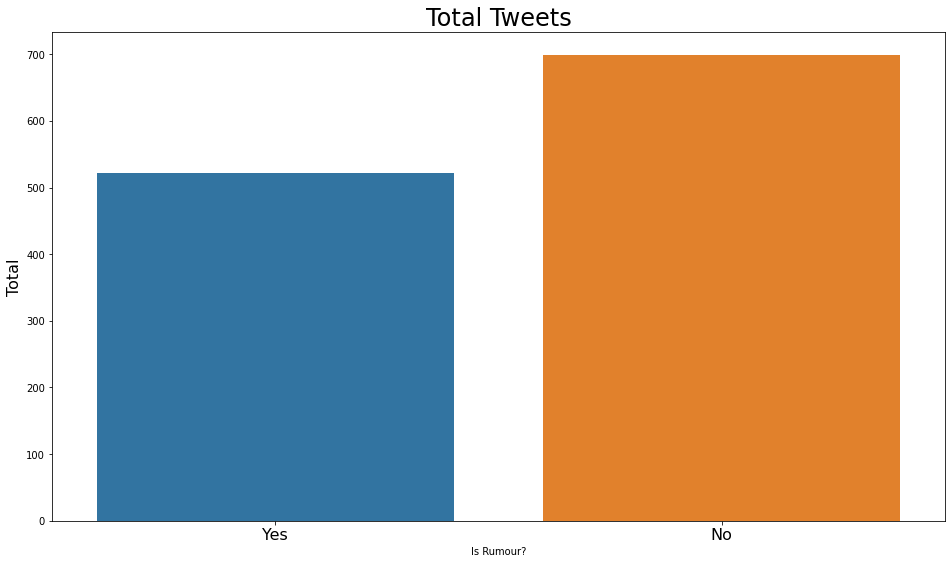

In [ ]:
plt.figure(figsize=(16,9))

sns.countplot(df.rumour)
plt.title('Total Tweets', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('Is Rumour?')
plt.xticks([0, 1], ['Yes', 'No'], fontsize=16)

plt.show()

El dataset parece estar medianamente balanceado en lo que respecta a cantidad de rumores

Vamos a ver cómo:

- Eliminar tags html.
- Eliminar/Reemplazar URLs (Done)
- Eliminar/Reemplazar Hashtags
- Eliminar/Reemplazar Menciones
- Case conversion.
- Eliminar caracteres especiales.
- Eliminar términos innecesarios.
- Segmentación y tokenización de texto
- Expandir contracciones.
- Corregir spelling.
- Normalización de inflecciones.



## Eliminar URLs
En este paso, se reemplazaran las URLs, por un placeholder.
Esto nos permitirá saber si se estaba utilizando una referencia a una URL dentro del tweet.

In [ ]:
# Removing URL's
def replace_urls(text):
    return re.sub(r'http\S+', 'URL', text)

In [ ]:
test_text = "BREAKING: Gunman takes hostages in cafe in Martin Place, Sydney  http://t.co/vj8G6m6VYs"
print(test_text)
print(replace_urls(test_text))

BREAKING: Gunman takes hostages in cafe in Martin Place, Sydney  http://t.co/vj8G6m6VYs
BREAKING: Gunman takes hostages in cafe in Martin Place, Sydney  URL


## Reemplazar Menciones
En este paso, se reemplazaran las menciones, por un placeholder. Esto nos permitirá saber si se estaba utilizando una mención a una cuenta dentro del tweet.

In [ ]:
# Removing URL's
def replace_mentions(text):
    return re.sub(r'@\S+', 'MENTION', text)

In [ ]:
test_text = "BREAKING: Gunman takes hostages in cafe in Martin Place @nytimes, Sydney  http://t.co/vj8G6m6VYs"
print(test_text)
print(replace_mentions(test_text))

BREAKING: Gunman takes hostages in cafe in Martin Place @nytimes, Sydney  http://t.co/vj8G6m6VYs
BREAKING: Gunman takes hostages in cafe in Martin Place MENTION Sydney  http://t.co/vj8G6m6VYs


## Reemplazar Hashtags
En este paso, se reemplazaran los Hashtags por un placeholder. Esto nos permitirá saber si se estaba utilizando un Hashtag dentro del tweet.

In [ ]:
# Removing URL's
def replace_hashtags(text):
    return re.sub(r'#\S+', 'HASHTAG', text)

In [ ]:
test_text = "#StartUps Uber Offers Free Rides During Sydney Hostage Crisis After Surge Pricing… http://t.co/r62oIX7twQ #NewsFeed http://t.co/Q0cULw3Dva"
print(test_text)
print(replace_hashtags(test_text))

#StartUps Uber Offers Free Rides During Sydney Hostage Crisis After Surge Pricing… http://t.co/r62oIX7twQ #NewsFeed http://t.co/Q0cULw3Dva
HASHTAG Uber Offers Free Rides During Sydney Hostage Crisis After Surge Pricing… http://t.co/r62oIX7twQ HASHTAG http://t.co/Q0cULw3Dva


## Case conversion
Vamos a convertir todo a lower case

In [ ]:
def to_lower_case(text):
  return text.lower();

In [ ]:
print(df['text'][0])
print(to_lower_case(df['text'][0]))

BREAKING: Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydney's Martin Place, as police man the doors outside #7NEWS
breaking: hostages are being forced to hold an isis flag at a lindt cafe in sydney's martin place, as police man the doors outside #7news


## Expandir las contracciones

In [ ]:
CONTRACTION_MAP = { # nuestro mapa de contracciones
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is", # notar que he's también podría ser he has, pero se opta por el uso más común
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would", # esta también podría haber sido I had
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def expand_contractions(sentence, contraction_mapping): # definimos una función que haga los reemplazos que corresponda
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), # las {} en la primera parte indican lo que hay que reemplzar por el parámetro
                                      flags=re.IGNORECASE|re.DOTALL) # dotall fuerza a que el punto matchee con cualquier caracter incluyendo el salto de línea
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                   if contraction_mapping.get(match)\
                                     else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
        
    expanded_sentence = contractions_pattern.sub(expand_match, sentence)
    return expanded_sentence

In [ ]:
print(expand_contractions(df['text'][0], CONTRACTION_MAP))

BREAKING: Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydney's Martin Place, as police man the doors outside #7NEWS


## Remover caracteres que no son letras o numeros

In [ ]:
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
test_text = "BREAKING: Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydney's Martin Place, as police man the doors outside #7NEWS"
print(test_text)
print(remove_special_characters(test_text))

BREAKING: Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydney's Martin Place, as police man the doors outside #7NEWS
BREAKING Hostages are being forced to hold an ISIS flag at a Lindt cafe in Sydneys Martin Place as police man the doors outside 7NEWS


## Tokenización

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
default_wt = nltk.word_tokenize
def tokenize(text):
  return default_wt(text)


In [ ]:
rr = tokenize(df['text'][0])
print('Total words in sample_text:', len(rr))
print('Sample text words :-')
print(np.array(rr))

Total words in sample_text: 29
Sample text words :-
['BREAKING' ':' 'Hostages' 'are' 'being' 'forced' 'to' 'hold' 'an' 'ISIS'
 'flag' 'at' 'a' 'Lindt' 'cafe' 'in' 'Sydney' "'s" 'Martin' 'Place' ','
 'as' 'police' 'man' 'the' 'doors' 'outside' '#' '7NEWS']


In [ ]:
ttt = "This is a text. This text has repetitions. The repetitions are a lot."
ppdf = pd.DataFrame(tokenize(ttt))

In [ ]:
ppdf.describe()

,0
count,16
unique,10
top,.
freq,3


## Corrección Ortográfica

In [ ]:
#Aplicamos NLTK processing.

#aplicamos el metodo de la distancia  
#https://www.geeksforgeeks.org/correcting-words-using-nltk-in-python/


# importing the nltk suite 
import nltk
  
# importing jaccard distance
# and ngrams from nltk.util
from nltk.metrics.distance  import edit_distance
from nltk.util import ngrams

# Downloading and importing
# package 'words' from nltk corpus
nltk.download('words')
from nltk.corpus import words

def spell_check(text):   
    correct_words = words.words()
    resultado = ""
    for word in text:
        temp = [(edit_distance(word, w),w) for w in correct_words if w[0]==word[0]]
        resultado = resultado + " " + (sorted(temp, key = lambda val:val[0])[0][1])
    return(resultado)


test_text = ('BREAKING Hostagers are being forced to hold an ISIS flag at a Lindt cafe in Sydneys Martin Place as police man the doors outside')
print("Texto original: ", test_text)
texto_tolower =  to_lower_case(test_text)
#print(texto_tolower)
texto_sin_hashtag = replace_hashtags(texto_tolower)
#print(texto_sin_hashtag)
texto_tokenizado = tokenize(texto_sin_hashtag)
#print(texto_tokenizado)


print('Texto corregido: ', spell_check(texto_tokenizado))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
Texto original:  BREAKING Hostagers are being forced to hold an ISIS flag at a Lindt cafe in Sydneys Martin Place as police man the doors outside
Texto corregido:   breaking hostager are being forced to hold an ibis flag at a lindo cade in sadness martin place as police man the dooms outside


En este paso, analizamos el uso del Spellchecker usando el metodo editdistance. Pudimos observar que aparecen errores al intentar corregir las palabras comunes dado que el metodo aplica una búsqueda por similitud de caracteres.
Dicho esto, descartamos el método dado que no se comporta como la mayoria de los correctores que comunmente se encuentran disponibles en el mercado.

In [ ]:
pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()


#test_text = (df['text'][0])
test_text = ('BREAKING: Hostagers are being forced to hold an ISIS flag at a Lindt cafe in Sydneys Martin Place, as police man the doors outside')
print("Texto original: ", test_text)
texto_tolower =  to_lower_case(test_text)
#print(texto_tolower)
texto_sin_hashtag = replace_hashtags(texto_tolower)
#print(texto_sin_hashtag)
texto_tokenizado = tokenize(texto_sin_hashtag)
#print(texto_tokenizado)


texto_a_spell = (texto_tokenizado) 


# find those words that may be misspelled
misspelled = spell.unknown(texto_a_spell)
print('Palabras con errores encontradas: ', misspelled)

resultado = ""
for word in texto_a_spell:
    # Get the one `most likely` answer
    #print(spell.correction(word))
    resultado = resultado + " " + (spell.correction(word)) #te dice cual a el best fit para esa palabra que parece que tiene un misspell
print('Texto corregido: ', resultado)

Texto original:  BREAKING: Hostagers are being forced to hold an ISIS flag at a Lindt cafe in Sydneys Martin Place, as police man the doors outside
Palabras con errores encontradas:  {'sydneys', 'lindt', 'hostagers'}
Texto corregido:   breaking : hostages are being forced to hold an isis flag at a linda cafe in sydney martin place , as police man the doors outside


En este caso, intentamos usar la librería SpellChecker de Python y encontramos que utiliza un diccionario para comprar palabras, este método parece más adecuado que el anterior pero así mismo detectamos que introduce mayor cantidad de errores a la hora de analizar texto, por esto mismo es que descartamos la idea de incorporar el corrector al pipeline.



## Remover Stopwords

In [ ]:
def remove_stopwords(text,is_lower_case=False):
    tokens = ToktokTokenizer().tokenize(text)

    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in nltk_stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in nltk_stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
remove_stopwords("The cat is under the table")

'cat table'

## Lemmatización

In [ ]:
def lemmatize_text(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    lemmatized = ''
    for word in doc:
        if not word.lemma_.startswith('-') :
            lemmatized += word.lemma_ + ' '
    
    return lemmatized

In [ ]:
lemmatize_text("The running pearson is training around the trees")

'the running pearson be train around the tree '

## Estadisticas del dataset antes del pre-procesamiento
Antes de aplicar el pipeline de pre-procesamiento, vamos a obtener algunas estadisticas del dataset.

Lo primero que vamos a hacer es ver cuales son las palabras mas comunes en el dataset.
Primero para el dataset completo.

In [ ]:
df_tk = df["text"].apply(tokenize)
accum_freq = nltk.FreqDist()
for tk in df_tk:
  new_freq = nltk.FreqDist(tk)
  accum_freq = accum_freq + new_freq

In [ ]:
accum_freq.tabulate(10)

          :           #        http           .         the      Sydney          in           , sydneysiege          to 
       1487        1149        1009         869         621         583         549         459         447         402 


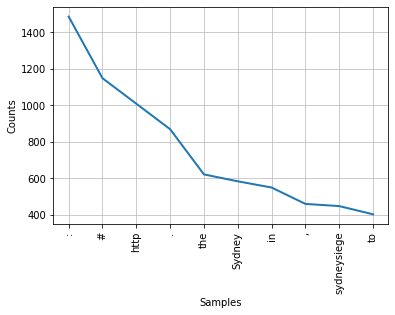

In [ ]:
accum_freq.plot(10)

Y luego discriminando si son rumores o no:

In [ ]:
mc = [i[0] for i in accum_freq.most_common(10)]
cfdist = nltk.ConditionalFreqDist(
    (row.rumour, word)
     for index, row in df.iterrows()
     for word in tokenize(row["text"]))

In [ ]:
cfdist.tabulate(samples=mc)

              :           #        http           .         the      Sydney          in           , sydneysiege          to 
 no         686         688         508         549         393         278         272         272         309         256 
yes         801         461         501         320         228         305         277         187         138         146 


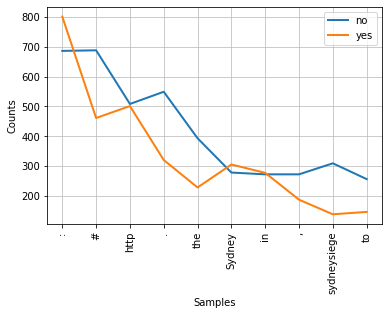

In [ ]:
cfdist.plot(samples=mc)

Como se puede ver, al no remover los simbolos y las stopwords las estadísticas que se obtienen no son para nada significativas.

Agregamos adicionalmente una nube de palabras para tener una visión mas gráfica del dataset.
**ACLARACIÓN: PARA QUE EL GRAFICO SEA MAS INTERESANTE SE REMOVIERON LAS STOPWORDS**

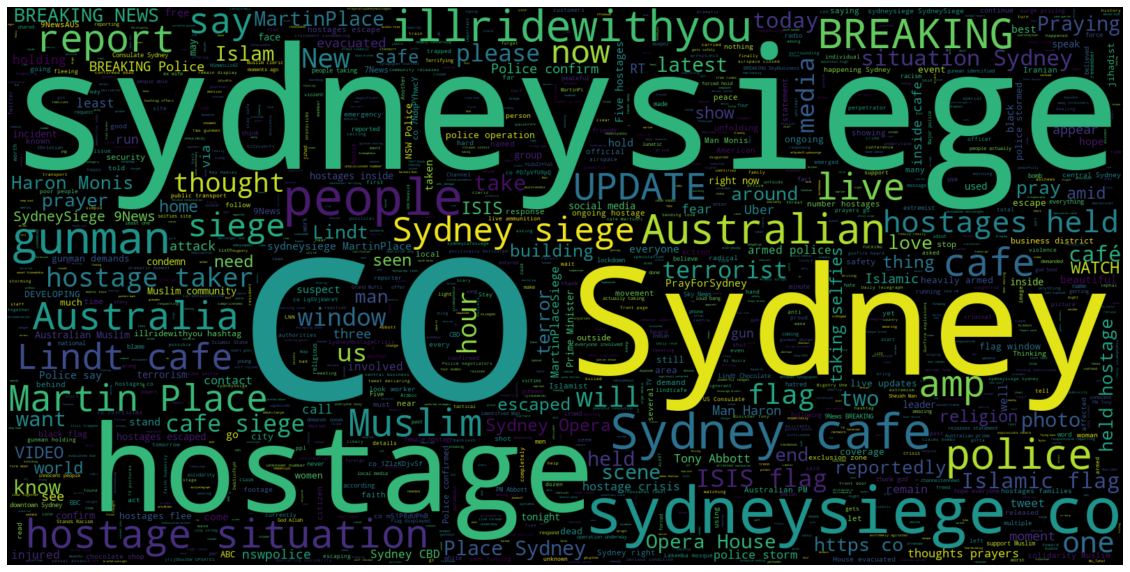

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

Las mismas estadisticas presentadas aqui, seran presentadas nuevamente luego de pre-procesar el dataset.

## Pipeline
Definimos el metodo que va a funcionar de Pipeline

In [ ]:
def pre_processing_pipeline(text):
  text = to_lower_case(text)
  text = replace_urls(text)
  text = replace_mentions(text)
  text = replace_hashtags(text)
  text = expand_contractions(text,CONTRACTION_MAP)
  text = remove_stopwords(text)
  text = remove_special_characters(text)
  #text = lemmatization(text)
  return text

Y lo aplicamos al feature 'text'

In [ ]:
df['text'] = df['text'].apply(pre_processing_pipeline)

In [ ]:
df

,text,verified,name,rumour
0,breaking hostages forced hold isis flag lindt cafe sydney martin place police man doors outside HASHTAG,True,Kristy Mayr,yes
1,breaking gunman takes hostages cafe martin place sydney URL,True,Daily Mail Australia,yes
2,update isis flag displayed window caf siege sydney martin place HASHTAG,True,Nine News Sydney,yes
3,HASHTAG hostages held siege taking place sydney lindt chocolat cafe martin place,True,Sky News Australia,yes
4,breaking sydney cafe martin place held hostages inside hands windows isis flag visible HASHTAG,True,Kristy Mayr,yes
...,...,...,...,...
1216,sydney siege ends police storm lindt cafe hostages run URL,True,The Guardian,no
1217,breaking news HASHTAG according police URL URL,True,Fox News,no
1218,watch gunfire erupt hostages flee chocolate shop HASHTAG ends URL URL,True,NBC News,no
1219,authorities confirmed HASHTAG police storm building URL URL,True,Yahoo UK News,no


## Repetimos el tema estadisticas luego de aplicar el pipeline

In [ ]:
df_tk = df["text"].apply(tokenize)
accum_freq = nltk.FreqDist()
for tk in df_tk:
  new_freq = nltk.FreqDist(tk)
  accum_freq = accum_freq + new_freq

In [ ]:
accum_freq.tabulate(10)

 HASHTAG      URL   sydney hostages     cafe   police  hostage  MENTION   people    siege 
    1147     1031      577      278      274      204      183      171      142      121 


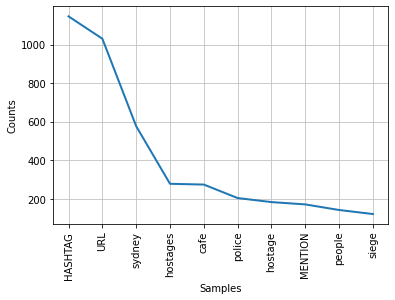

In [ ]:
accum_freq.plot(10)

In [ ]:
mc = [i[0] for i in accum_freq.most_common(10)]
cfdist = nltk.ConditionalFreqDist(
    (row.rumour, word)
     for index, row in df.iterrows()
     for word in tokenize(row["text"]))

In [ ]:
cfdist.tabulate(samples=mc)

     HASHTAG      URL   sydney hostages     cafe   police  hostage  MENTION   people    siege 
 no      686      516      283       83       72       99       59       87       75       53 
yes      461      515      294      195      202      105      124       84       67       68 


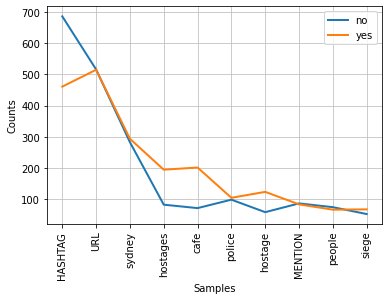

In [ ]:
cfdist.plot(samples=mc)

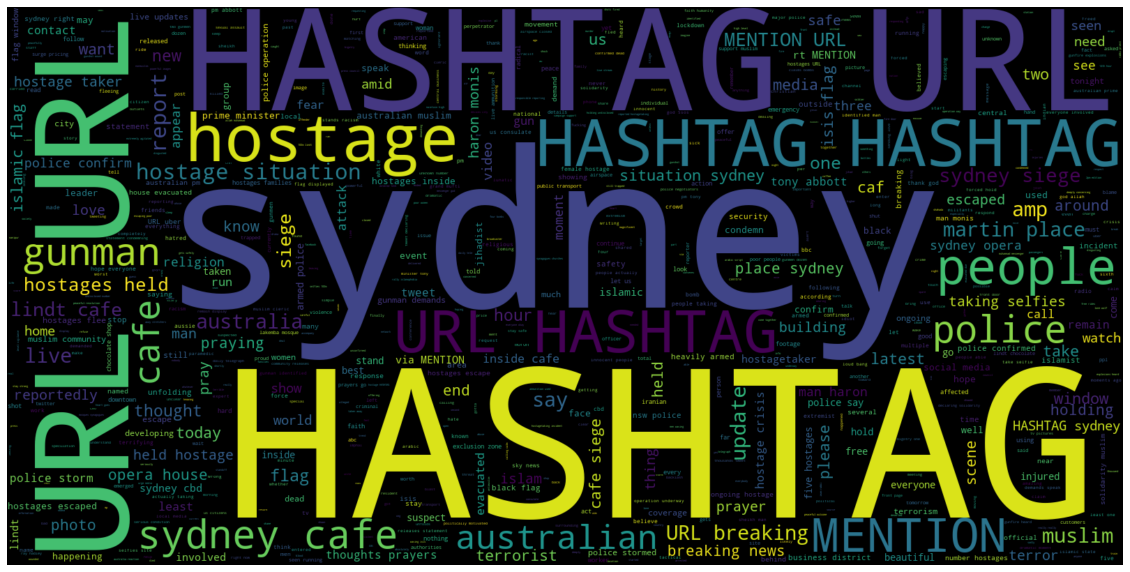

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()